In [0]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms

In [0]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [0]:
train_transform = transforms.Compose([
  transforms.Resize(224),
  transforms.RandomChoice((transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), transforms.RandomVerticalFlip(), transforms.RandomRotation(0.2))),
  transforms.ToTensor(),
  transforms.Normalize(mean = mean, std = std)                                      
]) 

In [0]:
test_transform = transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor(),
  transforms.Normalize(mean = mean, std = std)                                      
])

In [0]:
# !unzip '/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset.zip' -d '/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/'

In [0]:
train_dir = "/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset/train-cropped"
test_dir = "/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset/test-cropped"
valid_dir = "/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset/valid-cropped"
batch_size = 64
num_workers = 2

In [7]:
cd '/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset'

/content/drive/My Drive/Deep_Learning_Projects/Currency_Dataset/CurrencyDataset


In [0]:
train_set = datasets.ImageFolder("train-cropped", transform = train_transform)

In [0]:
val_set = datasets.ImageFolder("valid-cropped", transform = test_transform)

In [0]:
test_set = datasets.ImageFolder("test-cropped", transform = test_transform)

In [11]:
train_set

Dataset ImageFolder
    Number of datapoints: 4407
    Root location: train-cropped
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               RandomChoice(
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.3, 0.3])
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=(-0.2, 0.2), resample=False, expand=False)
           )
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [0]:
trainloader = torch.utils.data.DataLoader(train_set,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = num_workers)

In [0]:
val_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size = batch_size,
                                          shuffle = False,
                                          num_workers = num_workers)

In [0]:
testloader = torch.utils.data.DataLoader(test_set,
                                          batch_size = batch_size,
                                          shuffle = False,
                                          num_workers = num_workers)

In [0]:
dataset_sizes = {'train' : len(trainloader), 'val' : len(val_loader)}

In [16]:
dataset_sizes

{'train': 69, 'val': 14}

In [17]:
class_names = train_set.classes

print(np.size(class_names))
print(class_names)

9
['10', '100', '20', '200', '2000', '5', '50', '500', 'none']


#Import Model

In [0]:
from torchvision import models

In [0]:
model = models.mobilenet_v2(pretrained=True)

In [50]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

Freezing model parameters of above model

In [0]:
for param in model.parameters():
  param.requires_grad = False

In [52]:
num_ftrs = model.classifier[1].in_features
num_ftrs

1280

In [0]:
model.classifier  = nn.Sequential( nn.Dropout(p=0.2, inplace=False),
                           nn.Linear(num_ftrs, 1024),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(512, 9),
                           nn.LogSoftmax(dim=1))

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
print(device)

cuda:0


In [0]:
model = model.to(device)

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 2

In [0]:
checkpoint = torch.load('Model_checkpoints/mobileNetV2_checkpoint(YO97).pth')

In [59]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [0]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [0]:
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
accuracy = checkpoint['accuracy']

In [62]:
start_epoch = checkpoint['epoch']
start_epoch

15

In [0]:
for i in range(14, 19):
  for param in model.features[i].parameters():
    param.requires_grad = True

In [0]:
for param in model.classifier.parameters():
  param.requires_grad = True

In [65]:
model = model.to(device)

for epoch in range(num_epochs):
  
  #Training model
  model.train()
  counter = 0
  trainLoss = 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model.forward(inputs)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    trainLoss += loss.item()*inputs.size(0)

    #printing progress of training
    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(trainloader))  

  #Evaluating Model
  model.eval()
  counter = 0
  valLoss = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)  

      output = model.forward(inputs)

      valloss = criterion(output, labels)

      valLoss += valloss.item()*inputs.size(0)

      _, predicted = torch.max(output.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      counter += 1
      if(counter % 5 == 0):
        print(counter, "/", len(val_loader))

    train_loss.append(trainLoss/len(trainloader.dataset))
    val_loss.append(valLoss/len(val_loader.dataset))
    accuracy.append(100*correct/total)
    # Print out the information
    print("Accuracy of the model on test images: {}%".format(100*correct/total))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, trainLoss, valLoss))      

5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 94.14466130884041%
Epoch: 0 	Training Loss: 2599.896055 	Validation Loss: 191.334880
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 96.78530424799081%
Epoch: 1 	Training Loss: 1422.183078 	Validation Loss: 98.909650


In [67]:
model = model.to(device)
num_epochs = 20 
for epoch in range(num_epochs):
  
  #Training model
  model.train()
  counter = 0
  trainLoss = 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model.forward(inputs)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    trainLoss += loss.item()*inputs.size(0)

    #printing progress of training
    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(trainloader))  

  #Evaluating Model
  model.eval()
  counter = 0
  valLoss = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)  

      output = model.forward(inputs)

      valloss = criterion(output, labels)

      valLoss += valloss.item()*inputs.size(0)

      _, predicted = torch.max(output.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      counter += 1
      if(counter % 5 == 0):
        print(counter, "/", len(val_loader))

    train_loss.append(trainLoss/len(trainloader.dataset))
    val_loss.append(valLoss/len(val_loader.dataset))
    accuracy.append(100*correct/total)
    # Print out the information
    print("Accuracy of the model on test images: {}%".format(100*correct/total))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, trainLoss, valLoss))      

5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 97.47416762342135%
Epoch: 0 	Training Loss: 1030.750230 	Validation Loss: 92.136814
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 97.01492537313433%
Epoch: 1 	Training Loss: 903.377328 	Validation Loss: 132.778950
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 97.93340987370838%
Epoch: 2 	Training Loss: 722.217597 	Validation Loss: 54.587133
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 97.81859931113662%
Epoch: 3 	Training Loss: 530.596812 	Validation Loss: 49.963687
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 

In [0]:
torch.save({
    'epoch' : num_epochs,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_loss' : train_loss,
    'val_loss' : val_loss,
    'accuracy' : accuracy 
}, 'Model_checkpoints/mobileNetV2_checkpoint(Un98.9).pth')

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [79]:
model.eval()
counter = 0
valLoss = 0
Ypred = torch.tensor([])
with torch.no_grad():
  total = 0
  correct = 0
  for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)  

    output = model.forward(inputs)

    valloss = criterion(output, labels)

    valLoss += valloss.item()*inputs.size(0)

    _, predicted = torch.max(output.data, 1)
    pred = torch.tensor(predicted, dtype=torch.float)
    Ypred = torch.cat((Ypred ,pred), dim=0)
    # print(predicted)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(val_loader))

print("Accuracy of the model on test images: {}%".format(100*correct/total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


5 / 14
10 / 14
Accuracy of the model on test images: 98.85189437428244%


In [80]:
cm = confusion_matrix(val_set.targets, Ypred)
cm

array([[ 67,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0, 123,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,  75,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,  98,   0,   0,   0,   0,   0],
       [  0,   1,   0,   1,  21,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  72,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 107,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 179,   0],
       [  1,   0,   2,   0,   0,   1,   0,   1, 119]])

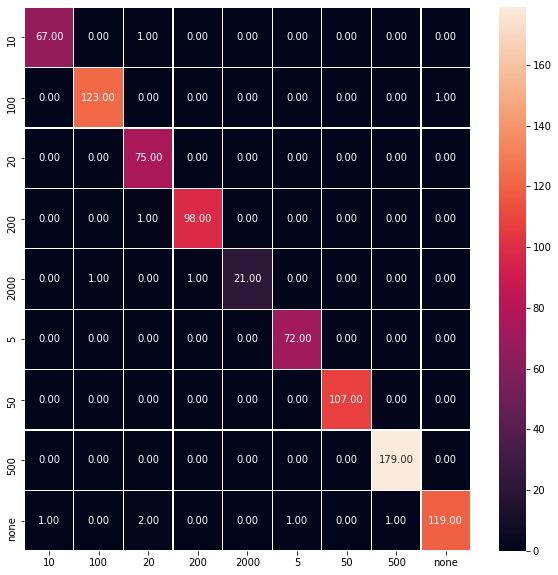

In [90]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, linewidths=0.05, fmt='.2f', xticklabels=train_set.classes, yticklabels=train_set.classes)


In [95]:
model.eval()
counter = 0
testLoss = 0
Ypred = torch.tensor([])
with torch.no_grad():
  total = 0
  correct = 0
  for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)  

    output = model.forward(inputs)

    testloss = criterion(output, labels)

    testLoss += valloss.item()*inputs.size(0)

    _, predicted = torch.max(output.data, 1)
    pred = torch.tensor(predicted, dtype=torch.float)
    Ypred = torch.cat((Ypred ,pred), dim=0)
    # print(predicted)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(testloader))

print("Accuracy of the model on test images: {}%".format(100*correct/total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


5 / 5
Accuracy of the model on test images: 71.42857142857143%


In [92]:
cm = confusion_matrix(test_set.targets, Ypred)
cm

array([[35,  3,  2,  0,  0,  1,  1,  0, 15],
       [ 0, 28,  0,  1,  0,  2,  5,  3, 23],
       [ 1,  0,  9,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1, 39,  0,  0,  0,  0,  2],
       [ 0,  1,  0,  0,  4,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 24,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  1, 38,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  1, 20,  1],
       [ 4,  3,  3,  6,  0,  0,  0,  0, 13]])

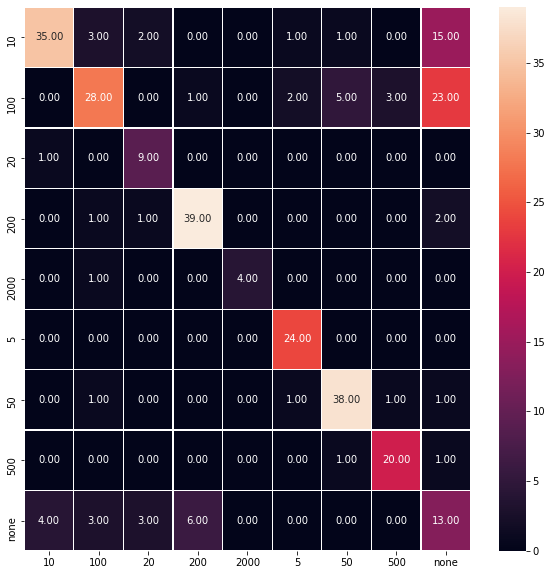

In [93]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, linewidths=0.05, fmt='.2f', xticklabels=train_set.classes, yticklabels=train_set.classes)


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 13

In [0]:
checkpoint = torch.load('Model_checkpoints/mobileNetV2_checkpoint(Un98.9).pth')

In [115]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [0]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [0]:
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
accuracy = checkpoint['accuracy']

In [118]:
start_epoch = checkpoint['epoch']
start_epoch

20

In [0]:
for i in range(14, 19):
  for param in model.features[i].parameters():
    param.requires_grad = True

In [0]:
for param in model.classifier.parameters():
  param.requires_grad = True

In [121]:
model = model.to(device)
num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
  
  #Training model
  model.train()
  counter = 0
  trainLoss = 0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model.forward(inputs)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    trainLoss += loss.item()*inputs.size(0)

    #printing progress of training
    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(trainloader))  

  #Evaluating Model
  model.eval()
  counter = 0
  valLoss = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)  

      output = model.forward(inputs)

      valloss = criterion(output, labels)

      valLoss += valloss.item()*inputs.size(0)

      _, predicted = torch.max(output.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      counter += 1
      if(counter % 5 == 0):
        print(counter, "/", len(val_loader))

    train_loss.append(trainLoss/len(trainloader.dataset))
    val_loss.append(valLoss/len(val_loader.dataset))
    curr_acc = 100*correct/total
    if(curr_acc > best_acc):
      best_acc = curr_acc
      best_model_wts = copy.deepcopy(model.state_dict())
    accuracy.append(100*correct/total)
    # Print out the information
    print("Accuracy of the model on test images: {}%".format(100*correct/total))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, trainLoss, valLoss))      

5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 98.85189437428244%
Epoch: 0 	Training Loss: 299.066766 	Validation Loss: 36.897436
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 98.85189437428244%
Epoch: 1 	Training Loss: 232.928950 	Validation Loss: 35.522646
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 98.27784156142366%
Epoch: 2 	Training Loss: 250.656119 	Validation Loss: 60.095220
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 69
35 / 69
40 / 69
45 / 69
50 / 69
55 / 69
60 / 69
65 / 69
5 / 14
10 / 14
Accuracy of the model on test images: 97.70378874856486%
Epoch: 3 	Training Loss: 323.414412 	Validation Loss: 69.781541
5 / 69
10 / 69
15 / 69
20 / 69
25 / 69
30 / 

In [122]:
best_acc

98.96670493685419

In [123]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [124]:
model.eval()
counter = 0
valLoss = 0
Ypred = torch.tensor([])
with torch.no_grad():
  total = 0
  correct = 0
  for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)  

    output = model.forward(inputs)

    valloss = criterion(output, labels)

    valLoss += valloss.item()*inputs.size(0)

    _, predicted = torch.max(output.data, 1)
    pred = torch.tensor(predicted, dtype=torch.float)
    Ypred = torch.cat((Ypred ,pred), dim=0)
    # print(predicted)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(val_loader))

print("Accuracy of the model on test images: {}%".format(100*correct/total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


5 / 14
10 / 14
Accuracy of the model on test images: 98.96670493685419%


In [0]:
torch.save({
    'epoch' : num_epochs,
    'model_state_dict' : best_model_wts,
    'optimizer_state_dict' : optimizer.state_dict(),
    'train_loss' : train_loss,
    'val_loss' : val_loss,
    'accuracy' : accuracy 
}, 'Model_checkpoints/mobileNetV2_checkpoint(Un99.6).pth')

In [126]:
model.eval()
counter = 0
testLoss = 0
Ypred = torch.tensor([])
with torch.no_grad():
  total = 0
  correct = 0
  for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)  

    output = model.forward(inputs)

    testloss = criterion(output, labels)

    testLoss += valloss.item()*inputs.size(0)

    _, predicted = torch.max(output.data, 1)
    pred = torch.tensor(predicted, dtype=torch.float)
    Ypred = torch.cat((Ypred ,pred), dim=0)
    # print(predicted)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    counter += 1
    if(counter % 5 == 0):
      print(counter, "/", len(testloader))

print("Accuracy of the model on test images: {}%".format(100*correct/total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


5 / 5
Accuracy of the model on test images: 67.68707482993197%
